<div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'>Métriques pour une classification binaire</div>

<table>
<tr>                                                                                   
     <th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/donnees_classif.png" width="256"></th>
     <th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/matrice_confusion.png" width="512"></th>
 </tr>
</table>

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Import librairies</div></b>

In [1]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os, sys, time, copy as cp, pickle
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import plotly.express as px
import plotly.graph_objs as go

font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
sns.set(font_scale=2)

In [2]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import NuSVC, SVC, OneClassSVM
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel

from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from lightgbm import LGBMClassifier
from xgboost  import XGBClassifier
from sklearn.metrics import roc_curve, auc

from sklearn.metrics  import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                             precision_score, recall_score, f1_score, fbeta_score, jaccard_score,  \
                             precision_recall_curve, average_precision_score, precision_recall_fscore_support, matthews_corrcoef

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Outils projet</div></b>

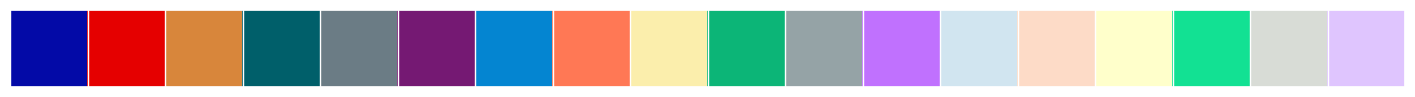

In [3]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
          ]
sns.palplot(sns.color_palette(palette))

In [4]:
from datetime import datetime as dt

repertoireRacine  = '.'
nomProjet         = 'Métriques pour une classification binaire'

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Separation des données pour l'apprentissage</div></b>

<img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/classification/echantillonApprentissageTest.png" width="800">

In [5]:
pickle_file = "dictionnaireChampignons.pickle"

with open(os.path.join(repertoireDonnees,pickle_file),'rb') as fichier:
    dictNValeurs = pickle.load(fichier)

In [6]:
donnees = pd.read_parquet(os.path.join(repertoireDonnees,'donnees_echantillons.parquet'))

In [7]:
X = donnees.drop(columns=['cible','échantillon'])
for colonne in X.columns:
    X[colonne] = X[colonne].apply(lambda x : dictNValeurs[colonne][x])
y = donnees['cible'].apply(lambda x : dictNValeurs['cible'][x])

In [8]:
X_train, X_test = X.loc[donnees['échantillon']=='apprentissage',:],\
                  X.loc[donnees['échantillon']=='test',:]
y_train, y_test = y[donnees['échantillon']=='apprentissage'],\
                  y[donnees['échantillon']=='test']

In [9]:
donnees

,cible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat,échantillon
0,toxique,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,white,white,white,one,pendant,black,scattered,urban,test
1,comestible,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,white,one,pendant,brown,numerous,grasses,test
2,comestible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,white,one,pendant,brown,numerous,meadows,apprentissage
3,toxique,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,white,one,pendant,black,scattered,urban,apprentissage
4,comestible,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,white,white,white,one,evanescent,brown,abundant,grasses,apprentissage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,comestible,knobbed,smooth,brown,no,none,attached,close,broad,yellow,...,smooth,orange,orange,orange,one,pendant,buff,clustered,leaves,apprentissage
8120,comestible,convex,smooth,brown,no,none,attached,close,broad,yellow,...,smooth,orange,orange,brown,one,pendant,buff,several,leaves,test
8121,comestible,flat,smooth,brown,no,none,attached,close,broad,brown,...,smooth,orange,orange,orange,one,pendant,buff,clustered,leaves,test
8122,toxique,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,...,silky,white,white,white,one,evanescent,white,several,leaves,apprentissage


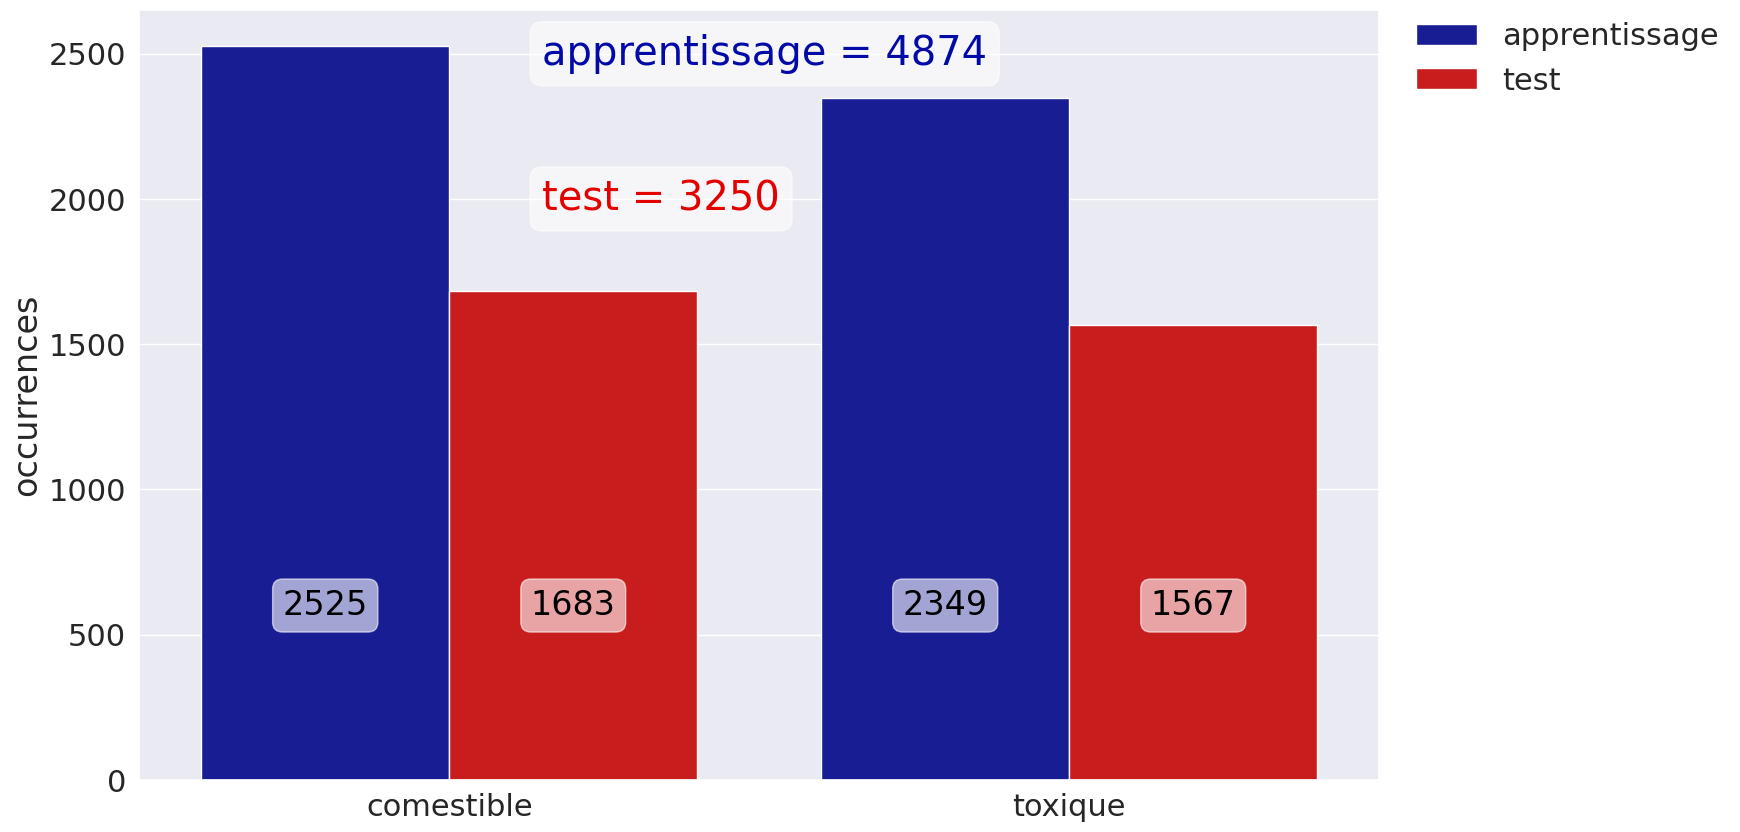

In [10]:
plt.figure(figsize=(16,10))
graph = sns.countplot(x='cible',
                      hue='échantillon',
                      data=donnees.sort_values(['cible','échantillon']), 
                      palette=palette[:2]
                     );

for i,nb in enumerate(donnees.groupby(['cible','échantillon']).cible.count()):
    if i%2 == 0 : val = i/2
    delta =  val - 0.2 +(i%2)*0.4
    graph.text(
                delta ,
                600,
                nb,
                color='black',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                verticalalignment='center',
                horizontalalignment='center',
               )

affichage = donnees.groupby('échantillon').agg({'cible':'count'})
graph.text(
                0.15 ,
                2500,
                f"apprentissage = {affichage.loc['apprentissage','cible']}",
                color="#030aa7",
                # rotation='vertical',
#                 size='large',
                fontsize='large',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                verticalalignment='center',
                horizontalalignment='left',
               )
graph.text(
                0.15 ,
                2000 ,
                f"test = {affichage.loc['test','cible']}",
                color="#e50000",
                # rotation='vertical',
#                 size='large',
                fontsize='large',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                verticalalignment='center',
                horizontalalignment='left',
               )

graph.set_ylabel('occurrences');
graph.set_xlabel('');
graph.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Déclaration du classificateur</div></b>

In [11]:
classificateur = LogisticRegression(
                C=0.81113,
                max_iter=800,
                penalty='l2',
                solver='lbfgs',
                n_jobs=-1
            )

classificateur.fit(X_train, y_train)

probabilites = classificateur.predict_proba(X_test)
predictions  = classificateur.predict(X_test) # 50%
observations = y_test.ravel()

accuracy     = accuracy_score (observations,predictions)
precision    = precision_score(observations,predictions)
sensibilite  = recall_score   (observations,predictions)
logloss      = log_loss       (observations,predictions)
hammingloss  = hamming_loss   (observations,predictions)
jaccard      = jaccard_score  (observations,predictions)
matthews     = matthews_corrcoef(observations,predictions)
f1           = f1_score       (observations,predictions)
fbeta05      = fbeta_score    (observations,predictions, beta=0.5)
fbeta1       = fbeta_score    (observations,predictions, beta=1)
fbeta2       = fbeta_score    (observations,predictions, beta=2)

print(f""" 
accuracy                   = {accuracy:0.4f} 
precision                  = {precision:0.4f} 
sensibilite                = {sensibilite :0.4f} 
logloss                    = {logloss:0.4f} 
hammingloss                = {hammingloss:0.4f} 
jaccard                    = {jaccard:0.4f} 
Matthews corr. coefficient = {matthews:0.4f} 
f1                         = {f1:0.4f} 
fbeta05                    = {fbeta05:0.4f} 
fbeta1                     = {fbeta1:0.4f} 
fbeta2                     = {fbeta2:0.4f} 
""")

 
accuracy                   = 0.9594 
precision                  = 0.9443 
sensibilite                = 0.9732 
logloss                    = 1.4639 
hammingloss                = 0.0406 
jaccard                    = 0.9203 
Matthews corr. coefficient = 0.9192 
f1                         = 0.9585 
fbeta05                    = 0.9499 
fbeta1                     = 0.9585 
fbeta2                     = 0.9673 



In [12]:
precision,sensibilite,f1,support = precision_recall_fscore_support(observations,predictions, beta=1)

affichage = pd.DataFrame({'Precision':precision,'Sensibilite':sensibilite,'F1':f1,'Support':support})
affichage.index = pd.Index([('comestible','0 / -'),('toxique','1 / +')])
affichage

,,Precision,Sensibilite,F1,Support
comestible,0 / -,0.974312,0.946524,0.960217,1683
toxique,1 / +,0.944272,0.973197,0.958517,1567


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Tableau des résultats</div></b>

In [13]:
dfROC = pd.DataFrame({'Probabilite':probabilites[:,1],
                      'Observation':observations,
                      'Prediction':predictions
                    }).sort_values(by='Probabilite',ascending=False)
dfROC.head(10)

,Probabilite,Observation,Prediction
3090,0.999986,1,1
2952,0.999984,1,1
3000,0.999982,1,1
2330,0.999938,0,1
2157,0.999928,0,1
2057,0.999923,0,1
2402,0.999920,0,1
2250,0.999914,0,1
1539,0.999911,1,1
1403,0.999896,1,1


In [14]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.DataFrame(probabilites,columns=['comestible', 
                             'toxique']).sort_values(by ='toxique',ascending=False).head()

,comestible,toxique
3090,0.000014,0.999986
2952,0.000016,0.999984
3000,0.000018,0.999982
2330,0.000062,0.999938
2157,0.000072,0.999928


# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Calculs des métriques</div></b>
<table>
    <tr>                                                                                   
         <th><b><div style='padding:15px;color:#030aa7;font-size:200%;text-align: center'></div></b></th>
         <th><b><div style='padding:15px;color:#030aa7;font-size:200%;text-align: center'>Matrice de confusion</div></b></th>
    </tr>
    <tr>                                                                                   
         <th>
                 <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/donnees_classif.png" width="512">
             </th>
             <th>
                 <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/matrice_confusion.png">
         </th>
    </tr>
</table>    



In [15]:
affichage = pd.crosstab(dfROC.Prediction,dfROC.Observation,margins=True,margins_name='Total')
affichage = affichage[[1,0,'Total']]
affichage = affichage.iloc[[1,0,2],:]
affichage.columns = pd.Index([('Observations','1 / +'),('Observations','0 / -'),('Observations','Total')])
affichage.index = pd.Index([('Predictions','1 / +'),('Predictions','0 / -'),('Predictions','Total')])
affichage

Observations            
                         1 / + 0 / - Total
Predictions 1 / +         1525    90  1615
            0 / -           42  1593  1635
            Total         1567  1683  3250

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Composants du jeu de données</div></b>

<table>
<tr>                                                                                   
     <th>
            <b><div style='color:#030aa7;font-size:120%;text-align: left'>Vrais Positifs VP</div></b>
            <b><div style='color:#030aa7;font-size:120%;text-align: left'>Vrais Négatifs VN</div></b>
            <b><div style='color:#030aa7;font-size:120%;text-align: left'>Faux Positifs</div></b>
            <b><div style='color:#030aa7;font-size:120%;text-align: left'>Faux Négatifs</div></b>
     </th>
     <th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/donnees_classif.png" width="256"></th>
 </tr>
</table>




In [16]:
affichage

Observations            
                         1 / + 0 / - Total
Predictions 1 / +         1525    90  1615
            0 / -           42  1593  1635
            Total         1567  1683  3250

In [17]:
vraisPositifs = affichage.loc[('Predictions','1 / +'),('Observations','1 / +')]
fauxPositifs  = affichage.loc[('Predictions','1 / +'),('Observations','0 / -')]
fauxNegatifs  = affichage.loc[('Predictions','0 / -'),('Observations','1 / +')]
vraisNegatifs = affichage.loc[('Predictions','0 / -'),('Observations','0 / -')]

print(f"""
vraisPositifs = {vraisPositifs}\tfauxPositifs  = {fauxPositifs}
fauxNegatifs  = {fauxNegatifs}\tvraisNegatifs = {vraisNegatifs}""")


vraisPositifs = 1525	fauxPositifs  = 90
fauxNegatifs  = 42	vraisNegatifs = 1593


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Prévalence</div></b>
<b><div style='padding:15px;color:#030aa7;font-size:120%;text-align: left'>Le rapport entre l'ensemble des cas positifs présents et l'ensemble de l’échantillon de donnée.</div></b>

<table>
    <tr>                                                                                   
         <th>
                 <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/donnees_classif.png" width="256">
         </th>        
         <th>
             <b><div style='padding:15px;color:#030aa7;font-size:200%;text-align: left'>Prévalence = $\frac{VP + FP}{VP + FP + VN + FN}$</div></b>
         </th>
             <th>
                 <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/prevalence.png" width="64">
         </th>
    </tr>
</table>  



In [18]:
affichage

Observations            
                         1 / + 0 / - Total
Predictions 1 / +         1525    90  1615
            0 / -           42  1593  1635
            Total         1567  1683  3250

In [19]:
Prevalence = dfROC.Observation.sum()/dfROC.Observation.count()
print(f"Prevalence = {Prevalence*100:0.2f}%")

Prevalence = 48.22%


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Niveau de précision globale</div></b>
<table>
    <tr>                                                                                   
         <th>
             <b><div style='padding:15px;color:#030aa7;font-size:200%;text-align: left'>Accuracy =  $ \frac{\sum_{i=0}^{n - 1} 1(Observations = Predictions)}{n}$=$\frac{VP+VN}{VP+FP+VN+FN}$</div></b>
         </th>
             <th>
                 <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/accuracy.png" width="128">
         </th>
    </tr>
</table>  

In [20]:
Accuracy = (vraisPositifs + vraisNegatifs) / (vraisPositifs + fauxPositifs + fauxNegatifs + vraisNegatifs) 
print(f"Accuracy = {Accuracy*100:0.4f}%")

Accuracy = 95.9385%


<b><div style='color:#030aa7;font-size:100%;text-align: left'>sklearn.metrics - <a style='color:#e50000'>*accuracy_score*</a></div></b>

In [21]:
Accuracy = accuracy_score(dfROC.Observation, dfROC.Prediction)
print(f"Accuracy = {Accuracy*100:0.4f}%")

Accuracy = 95.9385%


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Sensibilité ou Rappel</div></b>
<table>
    <tr>                                                                                   
         <th>
                 <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/donnees_classif.png" width="256">
         </th>        
         <th>
             <b><div style='padding:15px;color:#030aa7;font-size:200%;text-align: left'>Sensibilité = Rappel = $S_e$=  $\frac{VP}{VP + FN}$</div></b>
         </th>
             <th>
                 <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/sensibilite.png" width="64">
         </th>
    </tr>
</table>  

In [22]:
Sensibilite = vraisPositifs / (vraisPositifs + fauxNegatifs)
print(f"Sensibilite = {Sensibilite:0.8f}")

Sensibilite = 0.97319719


<b><div style='color:#030aa7;font-size:100%;text-align: left'>sklearn.metrics - <a style='color:#e50000'>*recall_score*</a></div></b>

In [23]:
Sensibilite = recall_score(dfROC.Observation, dfROC.Prediction)
print(f"Sensibilite = {Sensibilite:0.8f}")

Sensibilite = 0.97319719


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Spécificité</div></b>
<table>
    <tr>                                                                                   
         <th>
                 <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/donnees_classif.png" width="256">
         </th>        
         <th>
             <b><div style='padding:15px;color:#030aa7;font-size:200%;text-align: left'>Spécificité = $S_p$ = $\frac{VN}{FP + VN}$</div></b>
         </th>
             <th>
                 <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/specificite.png" width="64">
         </th>
    </tr>
</table>

In [24]:
Specificite       = vraisNegatifs / (fauxPositifs  + vraisNegatifs)
print(f"Specificite = {Specificite:0.8f}")

Specificite = 0.94652406


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Précision</div></b>
<table>
    <tr>                                                                                   
         <th>
                 <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/donnees_classif.png" width="256">
         </th>        
         <th>
             <b><div style='padding:15px;color:#030aa7;font-size:200%;text-align: left'>Précision =  $\frac{VP}{VP + FP}$</div></b>
         </th>
             <th>
                 <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/metriques/precision.png" width="64">
         </th>
    </tr>
</table>

In [25]:
Precision = vraisPositifs / (vraisPositifs + fauxPositifs) # Precision     = 0 if pd.isna(Precision) else Precision
print(f"Precision = {Precision:0.8f}")

Precision = 0.94427245


<b><div style='color:#030aa7;font-size:100%;text-align: left'>sklearn.metrics - <a style='color:#e50000'>*precision_score*</a></div></b>

In [26]:
Precision = precision_score(dfROC.Observation, dfROC.Prediction)
print(f"Precision = {Precision:0.8f}")

Precision = 0.94427245


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>$F_1$ et $F_\beta$</div></b>
<b><div style='padding:15px;color:#030aa7;font-size:120%;text-align: left'>Le F1 permet de résumer les valeurs de la precision et du Sensibilite(Rappel) en une seule métrique. Mathématiquement, le F1 est défini comme étant la moyenne harmonique de la precision et du Sensibilite(Rappel).</div></b>
<table>
    <tr>                                                                                   
         <th>
             <b><div style='padding:15px;color:#030aa7;font-family: Catamaran;font-size:200%;text-align: left'>$F_1$ =  $\frac{ 2 }{ \frac{ 1 }{Précision} +\frac{ 1 }{Sensibilite}}$ = $\frac{ 2 * VP }{ 2 * VP + FP + FN }$ =  $\frac{ VP }{ VP + \frac{1}{2}(FP + FN) }$</div></b>
              <b><div style='padding:15px;color:#030aa7;font-family: Catamaran;font-size:200%;text-align: left'>
                  $F_\beta$ = $\frac{ (1+\beta^2) * VP }{ (1+\beta^2) * VP + FP + \beta^2 * FN }$= $\frac{ VP }{ VP + \frac{ 1 }{1+\beta^2}(FP + \beta^2 * FN) }$</div></b>
         </th>
    </tr>
</table>
<div style='padding:15px;color:#030aa7;font-family: Catamaran;font-size:100%;text-align: left'>Pour $\beta \geqslant 1$, on accorde plus d’importance a la Sensibilite(Rappel) (autrement dit aux faux négatifs).</div>
<div style='padding:15px;color:#030aa7;font-family: Catamaran;font-size:100%;text-align: left'>Pour $\beta  \leqslant 1$, on accorde plus d’importance à la Précision (autrement dit aux faux positifs).</div>
<div style='padding:15px;color:#030aa7;font-family: Catamaran;font-size:100%;text-align: left'>Pour $\beta = 1$, on retrouve le F1-score, qui accorde autant d’importance à la precision qu’au recall.</div>


In [27]:
F1Score       = 2 * Precision * Sensibilite / (Precision + Sensibilite) # F1Score     = 0 if pd.isna(F1Score) else F1Score
print(f"F1Score = {F1Score:0.8f}")

F1Score = 0.95851666


<b><div style='color:#030aa7;font-size:100%;text-align: left'>sklearn.metrics - <a style='color:#e50000'>*precision_recall_fscore_support*</a></div></b>

<div style='color:#030aa7;font-size:100%;text-align: left'>Calculs uniquement pour la modalité : </b>1 / +</b></div>


In [28]:
print(f"""
Precision   = {Precision:0.8f}
Sensibilite = {Sensibilite:0.8f}
F1Score     = {F1Score:0.8f}""")


Precision   = 0.94427245
Sensibilite = 0.97319719
F1Score     = 0.95851666


<div style='color:#030aa7;font-size:100%;text-align: left'>Calculs pour les deux modalitées : </b>0 / - et 1 / +</b></div>

In [29]:
precision,sensibilite,f1,support = precision_recall_fscore_support(dfROC.Observation, dfROC.Prediction, beta=1)

affichage = pd.DataFrame({'Precision':precision,'Sensibilite':sensibilite,'F1':f1,'Support':support})
affichage.index = pd.Index([('comestible','0 / -'),('toxique','1 / +')])
affichage

,,Precision,Sensibilite,F1,Support
comestible,0 / -,0.974312,0.946524,0.960217,1683
toxique,1 / +,0.944272,0.973197,0.958517,1567


In [30]:
precision,sensibilite,f1,support = precision_recall_fscore_support(dfROC.Observation, dfROC.Prediction, beta=0.5)

affichage = pd.DataFrame({'Precision':precision,'Sensibilite':sensibilite,'fbeta05':f1,'Support':support})
affichage.index = pd.Index([('comestible','0 / -'),('toxique','1 / +')])
affichage

,,Precision,Sensibilite,fbeta05,Support
comestible,0 / -,0.974312,0.946524,0.968625,1683
toxique,1 / +,0.944272,0.973197,0.949919,1567


In [31]:
precision,sensibilite,f1,support = precision_recall_fscore_support(dfROC.Observation, dfROC.Prediction, beta=2)

affichage = pd.DataFrame({'Precision':precision,'Sensibilite':sensibilite,'fbeta2':f1,'Support':support})
affichage.index = pd.Index([('comestible','0 / -'),('toxique','1 / +')])
affichage

,,Precision,Sensibilite,fbeta2,Support
comestible,0 / -,0.974312,0.946524,0.951954,1683
toxique,1 / +,0.944272,0.973197,0.967271,1567
